In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
import random
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, MaxPool2D, UpSampling2D, Input, Reshape

from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical

from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [53]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [54]:
base_skin_dir = os.path.join('..', 'BTech Project/input/skin-cancer-mnist-ham10000')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.png'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [55]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [56]:
print(skin_df.columns)

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx'],
      dtype='object')


In [57]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,..\BTech Project/input/skin-cancer-mnist-ham10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,..\BTech Project/input/skin-cancer-mnist-ham10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,..\BTech Project/input/skin-cancer-mnist-ham10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,..\BTech Project/input/skin-cancer-mnist-ham10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,..\BTech Project/input/skin-cancer-mnist-ham10...,Benign keratosis-like lesions,2


In [58]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


In [59]:
from sklearn.utils import resample

samples_count = skin_df['cell_type'].value_counts()
majority_class = skin_df['cell_type'].isin([samples_count.idxmax()])
minority_class = skin_df['cell_type'].isin([samples_count.idxmin()])

df_majority = skin_df[majority_class]
df_minority = skin_df[minority_class]

print(skin_df['cell_type'].value_counts().idxmax())

Melanocytic nevi


In [60]:
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample without replacement
                                 n_samples=1500,    # to match minority class
                                 random_state=123)  # reproducible results
# Combine majority class with downsampled minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])


In [61]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,      # sample with replacement
                                 n_samples=3000,    # to match majority class
                                 random_state=42)   # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])


In [62]:
skin_df = skin_df[skin_df['cell_type'] != skin_df['cell_type'].value_counts().idxmax()]
skin_df = pd.concat([skin_df, df_majority_downsampled], sort=True)
print(skin_df['cell_type'].value_counts())

Melanocytic nevi                  1500
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64


In [63]:
# Image resizing

skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((128,96))))


In [64]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(96, 128, 3)    4810
Name: image, dtype: int64

In [65]:
features = skin_df.drop(columns=['cell_type_idx'],axis=1)
target = skin_df['cell_type_idx']

In [66]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.10,random_state=1234)

In [67]:
# Normalization
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [68]:
# Label Encoding
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [69]:
# Split training and validation
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [70]:
x_train = x_train.reshape(x_train.shape[0], *(96, 128, 3))
x_test = x_test.reshape(x_test.shape[0], *(96, 128, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(96, 128, 3))

## VGG16 + ResNet50 Classifier

In [71]:
from tensorflow.keras import backend as K
import tensorflow as tf


def sensitivity(y_true,y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives+K.epsilon())

def specificity(y_true,y_pred):
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    return true_negatives / (possible_negatives+K.epsilon())


def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [72]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from tensorflow.keras import optimizers

from keras.applications.vgg16 import VGG16


def vgg16(epochs, batch_size, classes, model_input):
    # create the base pre-trained model
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=model_input)
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    # add Dropout layer to reduce overfitting
    x = Dropout(0.2)(x)
    # and a logistic layer
    predictions = Dense(classes, activation='softmax', use_bias=True)(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False

    sgd = optimizers.SGD(lr=0.01, clipvalue=0.5)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy',sensitivity, precision,recall,specificity])

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=3, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)

    # train 
    history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                                  class_weight=class_weights,
                                  epochs = epochs, validation_data = (x_validate,y_validate),
                                  verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                                  callbacks=callbacks)

    return model, history

In [73]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

from tensorflow.keras.applications.resnet import ResNet50


def resnet50(epochs, batch_size, classes, model_input):
    # create the base pre-trained model
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=model_input)
  
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(classes, activation='softmax', use_bias=True)(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',sensitivity, precision,recall,specificity])

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=3, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
    
    # train 
    history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                                  class_weight=class_weights,
                                  epochs = epochs, validation_data = (x_validate,y_validate),
                                  verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                                  callbacks=callbacks)

    return model, history

In [74]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [75]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

C:\Users\saran\Sarang\env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [76]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

callbacks = [learning_rate_reduction, checkpoint, early]

In [77]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [78]:
from sklearn.utils import class_weight

total = 0
class_weights = {}
for i in skin_df['cell_type'].value_counts():
    total += i
class_weights = [1 - (i/total) for i in skin_df['cell_type'].value_counts()]

# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                  y_train)
# class_weights = dict(enumerate(class_weight))

In [79]:
class_weights = {0:0.6881496881496881, 1:0.7686070686070686, 2:0.7715176715176715, 3:0.8931392931392932, 4:0.932016632016632, 5:0.9704781704781704, 6:0.9760914760914761}

# !! I only did 1 epoch(s) here. Need to do more on a proper machine!!

In [80]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17632633428971155300
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5748293632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11306723624819774585
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [81]:
epochs = 100
batch_size = 10
classes = 7

model_input = Input(shape=(96, 128, 3))
vgg16_model, history = vgg16(epochs, batch_size, classes, model_input)
resnet50_model, resnet50_history = resnet50(epochs, batch_size, classes, model_input)

C:\Users\saran\Sarang\env\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
389/389 [==============================] - 14s 19ms/step - loss: 1.3038 - accuracy: 0.3906 - sensitivity: 0.1252 - precision: 0.5154 - recall: 0.1252 - specificity: 0.9892 - val_loss: 1.4064 - val_accuracy: 0.4180 - val_sensitivity: 0.1956 - val_precision: 0.6289 - val_recall: 0.1956 - val_specificity: 0.9811 - lr: 0.0100
Epoch 2/100
389/389 [==============================] - 6s 14ms/step - loss: 1.1711 - accuracy: 0.4472 - sensitivity: 0.2261 - precision: 0.6518 - recall: 0.2261 - specificity: 0.9809 - val_loss: 1.3092 - val_accuracy: 0.4619 - val_sensitivity: 0.2450 - val_precision: 0.6599 - val_recall: 0.2450 - val_specificity: 0.9781 - lr: 0.0100
Epoch 3/100
389/389 [==============================] - 6s 15ms/step - loss: 1.1067 - accuracy: 0.4804 - sensitivity: 0.2686 - precision: 0.6760 - recall: 0.2686 - specificity: 0.9787 - val_loss: 1.2592 - val_accuracy: 0.4734 - val_sensitivity: 0.2738 - val_precision: 0.6601 - val_recall: 0.2738 - val_specificity: 0.9767 - lr: 0

Epoch 11/100
389/389 [==============================] - 6s 14ms/step - loss: 0.9463 - accuracy: 0.5587 - sensitivity: 0.3786 - precision: 0.6838 - recall: 0.3786 - specificity: 0.9720 - val_loss: 1.1758 - val_accuracy: 0.5173 - val_sensitivity: 0.3893 - val_precision: 0.6449 - val_recall: 0.3893 - val_specificity: 0.9640 - lr: 0.0100
Epoch 12/100
388/389 [============================>.] - ETA: 0s - loss: 0.9395 - accuracy: 0.5715 - sensitivity: 0.3938 - precision: 0.7014 - recall: 0.3938 - specificity: 0.9717
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
389/389 [==============================] - 5s 14ms/step - loss: 0.9396 - accuracy: 0.5713 - sensitivity: 0.3933 - precision: 0.7008 - recall: 0.3933 - specificity: 0.9716 - val_loss: 1.1305 - val_accuracy: 0.5381 - val_sensitivity: 0.3511 - val_precision: 0.6953 - val_recall: 0.3511 - val_specificity: 0.9733 - lr: 0.0100
Epoch 13/100
389/389 [==============================] - 6s 14ms/step - loss: 0.9161 - 

389/389 [==============================] - 5s 14ms/step - loss: 0.8751 - accuracy: 0.5996 - sensitivity: 0.4222 - precision: 0.7242 - recall: 0.4222 - specificity: 0.9734 - val_loss: 1.1050 - val_accuracy: 0.5450 - val_sensitivity: 0.4114 - val_precision: 0.6730 - val_recall: 0.4114 - val_specificity: 0.9662 - lr: 0.0025
Epoch 21/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8629 - accuracy: 0.6042 - sensitivity: 0.4302 - precision: 0.7422 - recall: 0.4302 - specificity: 0.9747 - val_loss: 1.0901 - val_accuracy: 0.5681 - val_sensitivity: 0.3935 - val_precision: 0.6566 - val_recall: 0.3935 - val_specificity: 0.9651 - lr: 0.0012
Epoch 22/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8677 - accuracy: 0.5973 - sensitivity: 0.4320 - precision: 0.7351 - recall: 0.4320 - specificity: 0.9735 - val_loss: 1.0668 - val_accuracy: 0.5797 - val_sensitivity: 0.3868 - val_precision: 0.6713 - val_recall: 0.3868 - val_specificity: 0.9681 - lr: 0.0012
Epoch

389/389 [==============================] - 5s 14ms/step - loss: 0.8522 - accuracy: 0.6050 - sensitivity: 0.4326 - precision: 0.7333 - recall: 0.4326 - specificity: 0.9738 - val_loss: 1.0699 - val_accuracy: 0.5774 - val_sensitivity: 0.3890 - val_precision: 0.6579 - val_recall: 0.3890 - val_specificity: 0.9659 - lr: 3.1250e-04
Epoch 31/100
386/389 [============================>.] - ETA: 0s - loss: 0.8609 - accuracy: 0.6048 - sensitivity: 0.4269 - precision: 0.7231 - recall: 0.4269 - specificity: 0.9731
Epoch 31: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
389/389 [==============================] - 5s 14ms/step - loss: 0.8617 - accuracy: 0.6045 - sensitivity: 0.4262 - precision: 0.7231 - recall: 0.4262 - specificity: 0.9731 - val_loss: 1.0701 - val_accuracy: 0.5704 - val_sensitivity: 0.3868 - val_precision: 0.6567 - val_recall: 0.3868 - val_specificity: 0.9659 - lr: 3.1250e-04
Epoch 32/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8568 - acc

Epoch 40/100
387/389 [============================>.] - ETA: 0s - loss: 0.8461 - accuracy: 0.6081 - sensitivity: 0.4352 - precision: 0.7337 - recall: 0.4352 - specificity: 0.9739
Epoch 40: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.
389/389 [==============================] - 5s 14ms/step - loss: 0.8462 - accuracy: 0.6083 - sensitivity: 0.4353 - precision: 0.7334 - recall: 0.4353 - specificity: 0.9739 - val_loss: 1.0701 - val_accuracy: 0.5727 - val_sensitivity: 0.3935 - val_precision: 0.6607 - val_recall: 0.3935 - val_specificity: 0.9659 - lr: 3.9062e-05
Epoch 41/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8487 - accuracy: 0.6078 - sensitivity: 0.4350 - precision: 0.7346 - recall: 0.4350 - specificity: 0.9736 - val_loss: 1.0700 - val_accuracy: 0.5727 - val_sensitivity: 0.3935 - val_precision: 0.6581 - val_recall: 0.3935 - val_specificity: 0.9655 - lr: 1.9531e-05
Epoch 42/100
389/389 [==============================] - 5s 14ms/step - loss:

Epoch 50/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8528 - accuracy: 0.6114 - sensitivity: 0.4368 - precision: 0.7322 - recall: 0.4368 - specificity: 0.9732 - val_loss: 1.0699 - val_accuracy: 0.5704 - val_sensitivity: 0.3935 - val_precision: 0.6581 - val_recall: 0.3935 - val_specificity: 0.9655 - lr: 1.0000e-05
Epoch 51/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8509 - accuracy: 0.6122 - sensitivity: 0.4420 - precision: 0.7367 - recall: 0.4420 - specificity: 0.9736 - val_loss: 1.0698 - val_accuracy: 0.5704 - val_sensitivity: 0.3935 - val_precision: 0.6581 - val_recall: 0.3935 - val_specificity: 0.9655 - lr: 1.0000e-05
Epoch 52/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8498 - accuracy: 0.6161 - sensitivity: 0.4338 - precision: 0.7368 - recall: 0.4338 - specificity: 0.9744 - val_loss: 1.0699 - val_accuracy: 0.5704 - val_sensitivity: 0.3935 - val_precision: 0.6581 - val_recall: 0.3935 - val_specificity: 0.96

Epoch 60/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8505 - accuracy: 0.6042 - sensitivity: 0.4350 - precision: 0.7319 - recall: 0.4350 - specificity: 0.9733 - val_loss: 1.0697 - val_accuracy: 0.5727 - val_sensitivity: 0.3957 - val_precision: 0.6597 - val_recall: 0.3957 - val_specificity: 0.9655 - lr: 1.0000e-05
Epoch 61/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8549 - accuracy: 0.6011 - sensitivity: 0.4251 - precision: 0.7254 - recall: 0.4251 - specificity: 0.9726 - val_loss: 1.0697 - val_accuracy: 0.5727 - val_sensitivity: 0.3957 - val_precision: 0.6597 - val_recall: 0.3957 - val_specificity: 0.9655 - lr: 1.0000e-05
Epoch 62/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8581 - accuracy: 0.6096 - sensitivity: 0.4251 - precision: 0.7196 - recall: 0.4251 - specificity: 0.9726 - val_loss: 1.0698 - val_accuracy: 0.5727 - val_sensitivity: 0.3957 - val_precision: 0.6597 - val_recall: 0.3957 - val_specificity: 0.96

Epoch 70/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8504 - accuracy: 0.6099 - sensitivity: 0.4286 - precision: 0.7284 - recall: 0.4286 - specificity: 0.9737 - val_loss: 1.0696 - val_accuracy: 0.5751 - val_sensitivity: 0.3957 - val_precision: 0.6597 - val_recall: 0.3957 - val_specificity: 0.9655 - lr: 1.0000e-05
Epoch 71/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8500 - accuracy: 0.6055 - sensitivity: 0.4327 - precision: 0.7342 - recall: 0.4327 - specificity: 0.9736 - val_loss: 1.0696 - val_accuracy: 0.5751 - val_sensitivity: 0.3957 - val_precision: 0.6597 - val_recall: 0.3957 - val_specificity: 0.9655 - lr: 1.0000e-05
Epoch 72/100
389/389 [==============================] - 6s 14ms/step - loss: 0.8498 - accuracy: 0.6202 - sensitivity: 0.4374 - precision: 0.7416 - recall: 0.4374 - specificity: 0.9747 - val_loss: 1.0696 - val_accuracy: 0.5751 - val_sensitivity: 0.3957 - val_precision: 0.6597 - val_recall: 0.3957 - val_specificity: 0.96

Epoch 80/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8591 - accuracy: 0.6060 - sensitivity: 0.4281 - precision: 0.7192 - recall: 0.4281 - specificity: 0.9726 - val_loss: 1.0694 - val_accuracy: 0.5727 - val_sensitivity: 0.3957 - val_precision: 0.6597 - val_recall: 0.3957 - val_specificity: 0.9655 - lr: 1.0000e-05
Epoch 81/100
389/389 [==============================] - 6s 14ms/step - loss: 0.8470 - accuracy: 0.6140 - sensitivity: 0.4337 - precision: 0.7318 - recall: 0.4337 - specificity: 0.9741 - val_loss: 1.0694 - val_accuracy: 0.5751 - val_sensitivity: 0.3957 - val_precision: 0.6597 - val_recall: 0.3957 - val_specificity: 0.9655 - lr: 1.0000e-05
Epoch 82/100
389/389 [==============================] - 6s 14ms/step - loss: 0.8456 - accuracy: 0.6114 - sensitivity: 0.4355 - precision: 0.7382 - recall: 0.4355 - specificity: 0.9745 - val_loss: 1.0695 - val_accuracy: 0.5727 - val_sensitivity: 0.3957 - val_precision: 0.6597 - val_recall: 0.3957 - val_specificity: 0.96

Epoch 90/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8410 - accuracy: 0.6081 - sensitivity: 0.4424 - precision: 0.7464 - recall: 0.4424 - specificity: 0.9747 - val_loss: 1.0693 - val_accuracy: 0.5751 - val_sensitivity: 0.3957 - val_precision: 0.6597 - val_recall: 0.3957 - val_specificity: 0.9655 - lr: 1.0000e-05
Epoch 91/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8565 - accuracy: 0.6107 - sensitivity: 0.4350 - precision: 0.7316 - recall: 0.4350 - specificity: 0.9732 - val_loss: 1.0693 - val_accuracy: 0.5751 - val_sensitivity: 0.3957 - val_precision: 0.6597 - val_recall: 0.3957 - val_specificity: 0.9655 - lr: 1.0000e-05
Epoch 92/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8486 - accuracy: 0.6094 - sensitivity: 0.4386 - precision: 0.7309 - recall: 0.4386 - specificity: 0.9734 - val_loss: 1.0692 - val_accuracy: 0.5774 - val_sensitivity: 0.3957 - val_precision: 0.6597 - val_recall: 0.3957 - val_specificity: 0.96

Epoch 100/100
389/389 [==============================] - 5s 14ms/step - loss: 0.8489 - accuracy: 0.6155 - sensitivity: 0.4368 - precision: 0.7414 - recall: 0.4368 - specificity: 0.9747 - val_loss: 1.0693 - val_accuracy: 0.5751 - val_sensitivity: 0.3957 - val_precision: 0.6597 - val_recall: 0.3957 - val_specificity: 0.9655 - lr: 1.0000e-05
Epoch 1/100
389/389 [==============================] - 18s 35ms/step - loss: 1.6813 - accuracy: 0.4529 - sensitivity: 0.2542 - precision: 0.5909 - recall: 0.2542 - specificity: 0.9696 - val_loss: 4.8603 - val_accuracy: 0.3210 - val_sensitivity: 0.3221 - val_precision: 0.3232 - val_recall: 0.3221 - val_specificity: 0.8878 - lr: 0.0010
Epoch 2/100
389/389 [==============================] - 13s 33ms/step - loss: 1.1143 - accuracy: 0.5095 - sensitivity: 0.3218 - precision: 0.6385 - recall: 0.3218 - specificity: 0.9700 - val_loss: 7.1620 - val_accuracy: 0.4434 - val_sensitivity: 0.3350 - val_precision: 0.4802 - val_recall: 0.3350 - val_specificity: 0.9403 

Epoch 10/100
389/389 [==============================] - 13s 33ms/step - loss: 0.9147 - accuracy: 0.5826 - sensitivity: 0.4158 - precision: 0.7017 - recall: 0.4158 - specificity: 0.9699 - val_loss: 1.6225 - val_accuracy: 0.5843 - val_sensitivity: 0.4624 - val_precision: 0.6797 - val_recall: 0.4624 - val_specificity: 0.9637 - lr: 5.0000e-04
Epoch 11/100
389/389 [==============================] - 13s 33ms/step - loss: 0.8970 - accuracy: 0.5841 - sensitivity: 0.4292 - precision: 0.7102 - recall: 0.4292 - specificity: 0.9708 - val_loss: 2.7544 - val_accuracy: 0.5427 - val_sensitivity: 0.3799 - val_precision: 0.6658 - val_recall: 0.3799 - val_specificity: 0.9682 - lr: 5.0000e-04
Epoch 12/100
389/389 [==============================] - 13s 33ms/step - loss: 0.8842 - accuracy: 0.5859 - sensitivity: 0.4356 - precision: 0.7115 - recall: 0.4356 - specificity: 0.9704 - val_loss: 8.1627 - val_accuracy: 0.5520 - val_sensitivity: 0.4242 - val_precision: 0.6491 - val_recall: 0.4242 - val_specificity: 0

Epoch 20/100
389/389 [==============================] - 13s 33ms/step - loss: 0.7467 - accuracy: 0.6451 - sensitivity: 0.5312 - precision: 0.7436 - recall: 0.5312 - specificity: 0.9695 - val_loss: 1.0507 - val_accuracy: 0.6582 - val_sensitivity: 0.5306 - val_precision: 0.7405 - val_recall: 0.5306 - val_specificity: 0.9688 - lr: 1.2500e-04
Epoch 21/100
389/389 [==============================] - 13s 33ms/step - loss: 0.6948 - accuracy: 0.6734 - sensitivity: 0.5638 - precision: 0.7574 - recall: 0.5638 - specificity: 0.9700 - val_loss: 1.5000 - val_accuracy: 0.5912 - val_sensitivity: 0.4622 - val_precision: 0.6530 - val_recall: 0.4622 - val_specificity: 0.9600 - lr: 1.2500e-04
Epoch 22/100
389/389 [==============================] - 13s 33ms/step - loss: 0.6765 - accuracy: 0.6812 - sensitivity: 0.5824 - precision: 0.7567 - recall: 0.5824 - specificity: 0.9689 - val_loss: 1.1674 - val_accuracy: 0.5935 - val_sensitivity: 0.5278 - val_precision: 0.6629 - val_recall: 0.5278 - val_specificity: 0

389/389 [==============================] - 13s 33ms/step - loss: 0.5457 - accuracy: 0.7373 - sensitivity: 0.6714 - precision: 0.8070 - recall: 0.6714 - specificity: 0.9730 - val_loss: 1.1927 - val_accuracy: 0.6351 - val_sensitivity: 0.5591 - val_precision: 0.6780 - val_recall: 0.5591 - val_specificity: 0.9562 - lr: 3.1250e-05
Epoch 30/100
389/389 [==============================] - 13s 33ms/step - loss: 0.5300 - accuracy: 0.7578 - sensitivity: 0.6778 - precision: 0.8097 - recall: 0.6778 - specificity: 0.9732 - val_loss: 1.0166 - val_accuracy: 0.6351 - val_sensitivity: 0.5725 - val_precision: 0.6950 - val_recall: 0.5725 - val_specificity: 0.9584 - lr: 1.5625e-05
Epoch 31/100
389/389 [==============================] - 13s 33ms/step - loss: 0.5222 - accuracy: 0.7558 - sensitivity: 0.6896 - precision: 0.8137 - recall: 0.6896 - specificity: 0.9738 - val_loss: 1.0081 - val_accuracy: 0.6467 - val_sensitivity: 0.5903 - val_precision: 0.7191 - val_recall: 0.5903 - val_specificity: 0.9618 - lr: 1

389/389 [==============================] - 13s 33ms/step - loss: 0.4843 - accuracy: 0.7720 - sensitivity: 0.7090 - precision: 0.8278 - recall: 0.7090 - specificity: 0.9755 - val_loss: 1.0970 - val_accuracy: 0.6651 - val_sensitivity: 0.5968 - val_precision: 0.7087 - val_recall: 0.5968 - val_specificity: 0.9599 - lr: 1.0000e-05
Epoch 40/100
389/389 [==============================] - 13s 33ms/step - loss: 0.4728 - accuracy: 0.7753 - sensitivity: 0.7165 - precision: 0.8245 - recall: 0.7165 - specificity: 0.9747 - val_loss: 1.1357 - val_accuracy: 0.6513 - val_sensitivity: 0.5834 - val_precision: 0.6899 - val_recall: 0.5834 - val_specificity: 0.9569 - lr: 1.0000e-05
Epoch 41/100
389/389 [==============================] - 13s 33ms/step - loss: 0.4891 - accuracy: 0.7738 - sensitivity: 0.7177 - precision: 0.8225 - recall: 0.7177 - specificity: 0.9743 - val_loss: 1.0668 - val_accuracy: 0.6628 - val_sensitivity: 0.5948 - val_precision: 0.7064 - val_recall: 0.5948 - val_specificity: 0.9592 - lr: 1

389/389 [==============================] - 13s 33ms/step - loss: 0.4662 - accuracy: 0.7766 - sensitivity: 0.7288 - precision: 0.8268 - recall: 0.7288 - specificity: 0.9749 - val_loss: 1.0074 - val_accuracy: 0.6467 - val_sensitivity: 0.5948 - val_precision: 0.6936 - val_recall: 0.5948 - val_specificity: 0.9566 - lr: 1.0000e-05
Epoch 50/100
389/389 [==============================] - 13s 33ms/step - loss: 0.4566 - accuracy: 0.7895 - sensitivity: 0.7361 - precision: 0.8330 - recall: 0.7361 - specificity: 0.9752 - val_loss: 0.9878 - val_accuracy: 0.6582 - val_sensitivity: 0.6037 - val_precision: 0.7121 - val_recall: 0.6037 - val_specificity: 0.9595 - lr: 1.0000e-05
Epoch 51/100
389/389 [==============================] - 13s 33ms/step - loss: 0.4513 - accuracy: 0.7988 - sensitivity: 0.7460 - precision: 0.8428 - recall: 0.7460 - specificity: 0.9767 - val_loss: 0.9911 - val_accuracy: 0.6582 - val_sensitivity: 0.6035 - val_precision: 0.6979 - val_recall: 0.6035 - val_specificity: 0.9569 - lr: 1

389/389 [==============================] - 13s 33ms/step - loss: 0.4152 - accuracy: 0.8029 - sensitivity: 0.7590 - precision: 0.8431 - recall: 0.7590 - specificity: 0.9765 - val_loss: 1.0836 - val_accuracy: 0.6467 - val_sensitivity: 0.5965 - val_precision: 0.6723 - val_recall: 0.5965 - val_specificity: 0.9521 - lr: 1.0000e-05
Epoch 60/100
389/389 [==============================] - 13s 33ms/step - loss: 0.4096 - accuracy: 0.8196 - sensitivity: 0.7769 - precision: 0.8517 - recall: 0.7769 - specificity: 0.9776 - val_loss: 1.0973 - val_accuracy: 0.6397 - val_sensitivity: 0.6057 - val_precision: 0.6706 - val_recall: 0.6057 - val_specificity: 0.9506 - lr: 1.0000e-05
Epoch 61/100
389/389 [==============================] - 13s 33ms/step - loss: 0.4038 - accuracy: 0.8178 - sensitivity: 0.7731 - precision: 0.8565 - recall: 0.7731 - specificity: 0.9784 - val_loss: 1.0106 - val_accuracy: 0.6490 - val_sensitivity: 0.6104 - val_precision: 0.6820 - val_recall: 0.6104 - val_specificity: 0.9525 - lr: 1

389/389 [==============================] - 13s 33ms/step - loss: 0.3753 - accuracy: 0.8330 - sensitivity: 0.7910 - precision: 0.8645 - recall: 0.7910 - specificity: 0.9793 - val_loss: 0.9955 - val_accuracy: 0.6790 - val_sensitivity: 0.6372 - val_precision: 0.7040 - val_recall: 0.6372 - val_specificity: 0.9558 - lr: 1.0000e-05
Epoch 70/100
389/389 [==============================] - 13s 33ms/step - loss: 0.3764 - accuracy: 0.8350 - sensitivity: 0.7978 - precision: 0.8667 - recall: 0.7978 - specificity: 0.9796 - val_loss: 1.0050 - val_accuracy: 0.6790 - val_sensitivity: 0.6501 - val_precision: 0.7140 - val_recall: 0.6501 - val_specificity: 0.9573 - lr: 1.0000e-05
Epoch 71/100
389/389 [==============================] - 13s 33ms/step - loss: 0.3600 - accuracy: 0.8374 - sensitivity: 0.8057 - precision: 0.8702 - recall: 0.8057 - specificity: 0.9802 - val_loss: 1.0391 - val_accuracy: 0.6536 - val_sensitivity: 0.6238 - val_precision: 0.6867 - val_recall: 0.6238 - val_specificity: 0.9528 - lr: 1

389/389 [==============================] - 13s 34ms/step - loss: 0.3205 - accuracy: 0.8564 - sensitivity: 0.8278 - precision: 0.8852 - recall: 0.8278 - specificity: 0.9822 - val_loss: 1.0663 - val_accuracy: 0.6651 - val_sensitivity: 0.6389 - val_precision: 0.6947 - val_recall: 0.6389 - val_specificity: 0.9535 - lr: 1.0000e-05
Epoch 80/100
389/389 [==============================] - 13s 34ms/step - loss: 0.3239 - accuracy: 0.8551 - sensitivity: 0.8285 - precision: 0.8836 - recall: 0.8285 - specificity: 0.9818 - val_loss: 1.2000 - val_accuracy: 0.6467 - val_sensitivity: 0.6303 - val_precision: 0.6841 - val_recall: 0.6303 - val_specificity: 0.9517 - lr: 1.0000e-05
Epoch 81/100
389/389 [==============================] - 13s 33ms/step - loss: 0.3229 - accuracy: 0.8569 - sensitivity: 0.8294 - precision: 0.8862 - recall: 0.8294 - specificity: 0.9824 - val_loss: 1.1755 - val_accuracy: 0.6397 - val_sensitivity: 0.6171 - val_precision: 0.6784 - val_recall: 0.6171 - val_specificity: 0.9510 - lr: 1

389/389 [==============================] - 13s 33ms/step - loss: 0.2842 - accuracy: 0.8664 - sensitivity: 0.8459 - precision: 0.8872 - recall: 0.8459 - specificity: 0.9822 - val_loss: 1.0705 - val_accuracy: 0.6651 - val_sensitivity: 0.6545 - val_precision: 0.6949 - val_recall: 0.6545 - val_specificity: 0.9521 - lr: 1.0000e-05
Epoch 90/100
389/389 [==============================] - 13s 34ms/step - loss: 0.2801 - accuracy: 0.8798 - sensitivity: 0.8567 - precision: 0.8963 - recall: 0.8567 - specificity: 0.9834 - val_loss: 1.1024 - val_accuracy: 0.6605 - val_sensitivity: 0.6414 - val_precision: 0.6950 - val_recall: 0.6414 - val_specificity: 0.9532 - lr: 1.0000e-05
Epoch 91/100
389/389 [==============================] - 13s 33ms/step - loss: 0.2784 - accuracy: 0.8755 - sensitivity: 0.8507 - precision: 0.8953 - recall: 0.8507 - specificity: 0.9835 - val_loss: 1.1303 - val_accuracy: 0.6605 - val_sensitivity: 0.6347 - val_precision: 0.6912 - val_recall: 0.6347 - val_specificity: 0.9524 - lr: 1

389/389 [==============================] - 13s 33ms/step - loss: 0.2383 - accuracy: 0.8963 - sensitivity: 0.8773 - precision: 0.9145 - recall: 0.8773 - specificity: 0.9863 - val_loss: 1.1001 - val_accuracy: 0.6651 - val_sensitivity: 0.6478 - val_precision: 0.6843 - val_recall: 0.6478 - val_specificity: 0.9506 - lr: 1.0000e-05
Epoch 100/100
389/389 [==============================] - 13s 33ms/step - loss: 0.2297 - accuracy: 0.8955 - sensitivity: 0.8799 - precision: 0.9135 - recall: 0.8799 - specificity: 0.9861 - val_loss: 1.1453 - val_accuracy: 0.6513 - val_sensitivity: 0.6369 - val_precision: 0.6818 - val_recall: 0.6369 - val_specificity: 0.9506 - lr: 1.0000e-05


In [82]:
tf.keras.models.save_model(vgg16_model, 'vgg16_model.h5')
tf.keras.models.save_model(resnet50_model, 'resnet50_model.h5')

### Freeze all layers except FC and Dense Layer

In [83]:
# the first 249 layers and unfreeze the rest:
for layer in vgg16_model.layers[:-2]:
   layer.trainable = False
for layer in vgg16_model.layers[-2:]:
   layer.trainable = True

In [84]:
from tensorflow.keras.optimizers import SGD
vgg16_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy',sensitivity, precision,recall,specificity])

### Fine-Tune Top 2 Layers

In [85]:
vgg16_model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size))

C:\Users\saran\AppData\Local\Temp\ipykernel_15208\218619459.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg16_model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size))


390/390 [==============================] - 6s 13ms/step - loss: 1.0044 - accuracy: 0.6073 - sensitivity: 0.4321 - precision: 0.7363 - recall: 0.4321 - specificity: 0.9738


### Models Evaluation

In [86]:
vgg16_model.evaluate(x_test, y_test, verbose=1)

16/16 [==============================] - 1s 39ms/step - loss: 1.0798 - accuracy: 0.5967 - sensitivity: 0.4199 - precision: 0.6543 - recall: 0.4199 - specificity: 0.9691


[1.0797761678695679,
 0.5966736078262329,
 0.419921875,
 0.6542642712593079,
 0.419921875,
 0.969075620174408]

In [89]:
loss, accuracy, sensitivity, precision, recall, specificity = vgg16_model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v,sensitivity_v, precision_v, recall_v, specificity_v = vgg16_model.evaluate(x_validate, y_validate, verbose=1)

print("VGG16")
print("Validation: val_accuracy = %f  -  val_loss = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  -  loss = %f" % (accuracy, loss))

14/14 [==============================] - 0s 20ms/step - loss: 1.0660 - accuracy: 0.5704 - sensitivity: 0.3913 - precision: 0.6713 - recall: 0.3913 - specificity: 0.9673
VGG16
Validation: val_accuracy = 0.570439  -  val_loss = 1.065979
Test: accuracy = 0.596674  -  loss = 1.079776


In [110]:
vgg16_model.evaluate(x_test, y_test, verbose=1)

16/16 [==============================] - 1s 20ms/step - loss: 1.0798 - accuracy: 0.5967 - sensitivity: 0.4199 - precision: 0.6543 - recall: 0.4199 - specificity: 0.9691


[1.0797761678695679,
 0.5966736078262329,
 0.419921875,
 0.6542642712593079,
 0.419921875,
 0.969075620174408]

In [88]:
loss, accuracy, sensitivity, precision, recall, specificity = resnet50_model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v,sensitivity_v, precision_v, recall_v, specificity_v = resnet50_model.evaluate(x_validate, y_validate, verbose=1)
print("ResNet50")
print("Validation: val_accuracy = %f  -  val_loss = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  -  loss = %f" % (accuracy, loss))

14/14 [==============================] - 0s 16ms/step - loss: 1.1453 - accuracy: 0.6513 - sensitivity: 0.6369 - precision: 0.6818 - recall: 0.6369 - specificity: 0.9506
ResNet50
Validation: val_accuracy = 0.651270  -  val_loss = 1.145299
Test: accuracy = 0.686071  -  loss = 1.120638


In [109]:
resnet50_model.evaluate(x_test, y_test, verbose=1)

16/16 [==============================] - 0s 17ms/step - loss: 1.1206 - accuracy: 0.6861 - sensitivity: 0.6270 - precision: 0.6541 - recall: 0.6270 - specificity: 0.9443


[1.1206378936767578,
 0.6860706806182861,
 0.626953125,
 0.6540956497192383,
 0.626953125,
 0.9443359375]

### Ensemble CNN (VGG16 + ResNet50)

In [127]:
from keras.layers import Average

ensembled_models = [vgg16_model, resnet50_model]
outputs = Average()([m.outputs[0] for m in ensembled_models])
ensemble_model = Model(model_input, outputs, name='ensemble')
# sgd = optimizers.SGD(lr=0.01, clipvalue=0.5)
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 48, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 48, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 24, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 24, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 24, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 24, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 12, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 12, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 12, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 12, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 6, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 6, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 6, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 6, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 6, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 6, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 6, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 6, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 3, 4, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 block2_conv1 (Conv2D)          (None, 48, 64, 128)  73856       ['block1_pool[0][0]']            
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 3, 4, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2_conv2 (Conv2D)          (None, 48, 64, 128)  147584      ['block2_conv1[0][0]']           
                                                                                                  
 conv5_blo

 dropout (Dropout)              (None, 1024)         0           ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 1024)         25166848    ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 7)            7175        ['dropout[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 7)            7175        ['dense_2[0][0]']                
                                                                                                  
 average_14 (Average)           (None, 7)            0           ['dense_1[0][0]',                
                                                                  'dense_3[0][0]']                
          

In [128]:
ensemble_model.evaluate(x_test, y_test, verbose=1)

16/16 [==============================] - 2s 33ms/step - loss: 0.8354 - accuracy: 0.6944


[0.8353791832923889, 0.6943867206573486]

In [129]:
loss, accuracy = ensemble_model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v= ensemble_model.evaluate(x_validate, y_validate, verbose=1)
print("Ensemble")
print("Validation: val_accuracy = %f  -  val_loss = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  -  loss = %f" % (accuracy, loss))

14/14 [==============================] - 0s 33ms/step - loss: 0.8759 - accuracy: 0.6767
Ensemble
Validation: val_accuracy = 0.676674  -  val_loss = 0.875913
Test: accuracy = 0.694387  -  loss = 0.835379


In [130]:
tf.keras.models.save_model(ensemble_model, 'ensemble_model.h5')

## U-Net

In [131]:
def unet():
    input_shape = (96, 128, 3)
    img_input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)

    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    
    pred = Reshape((96, 128))(x)
    model = Model(inputs=img_input, outputs=pred)
    model.load_weights('../BTech Project/input/unet-weights/unet_100_epoch.h5')
    
    return model

unet_model = unet()

In [132]:
def enhance(img):
    sub = (unet_model.predict(img.reshape(1,96,128,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

In [133]:
import cv2

def applyMask(img):
    mask = np.array(enhance(img).reshape(96, 128), dtype=np.uint8)
    
    res = cv2.bitwise_and(img,img,mask = mask)
    
    return res

## Apply Mask

In [134]:
random_sample_df = skin_df.sample(n=5)
print(random_sample_df['cell_type'].value_counts())

img_list = [img for img in random_sample_df['image']]

seg_img_list = [applyMask(img) for img in img_list]

Melanocytic nevi                  2
Benign keratosis-like lesions     1
Actinic keratoses                 1
Melanoma                          1
Name: cell_type, dtype: int64
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


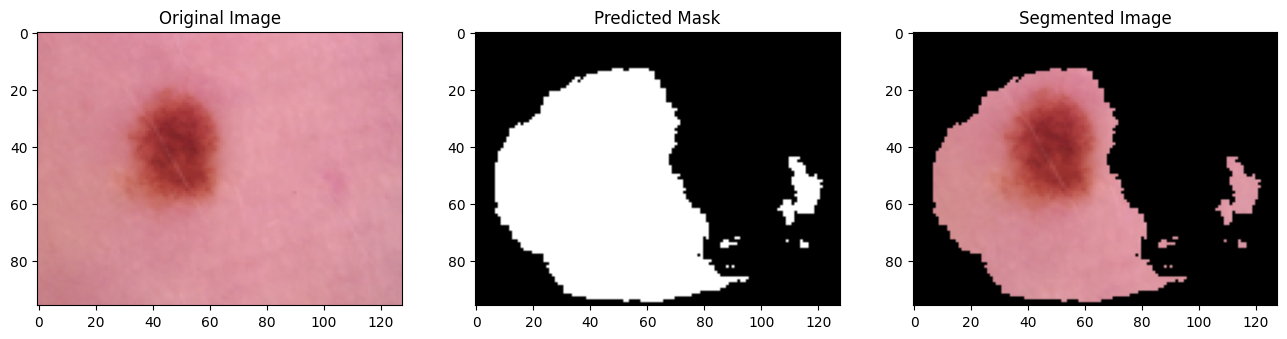

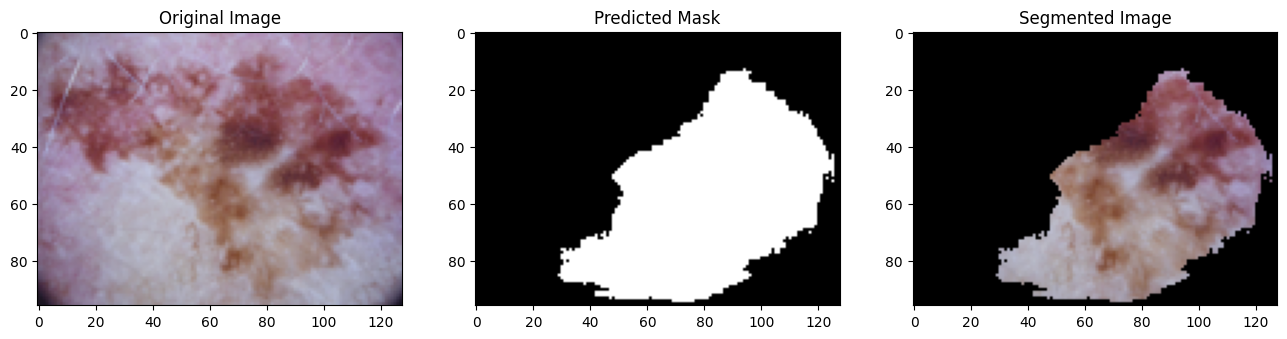

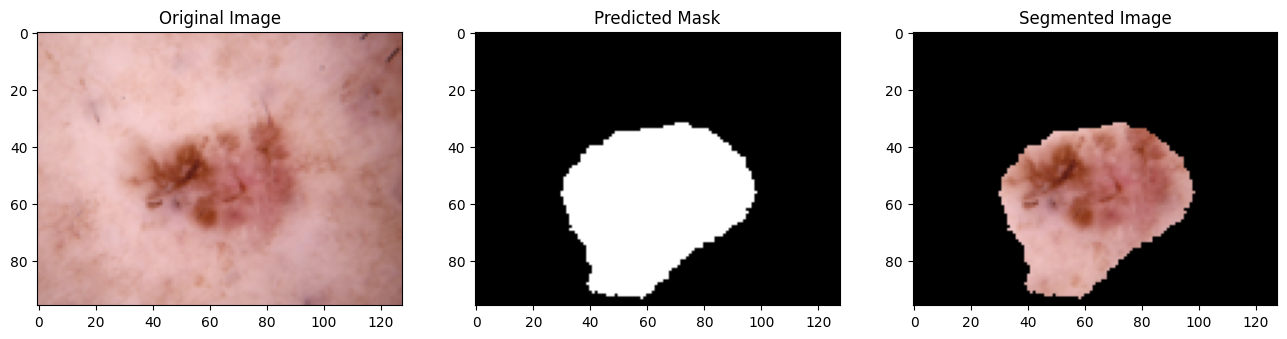

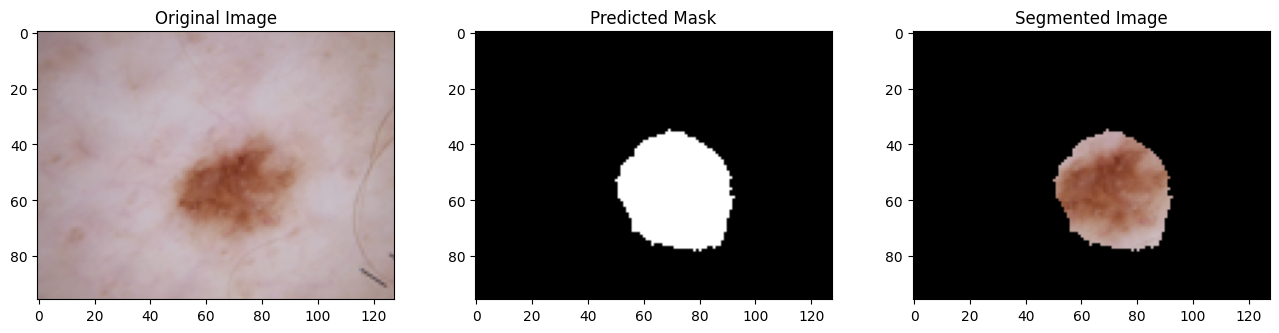

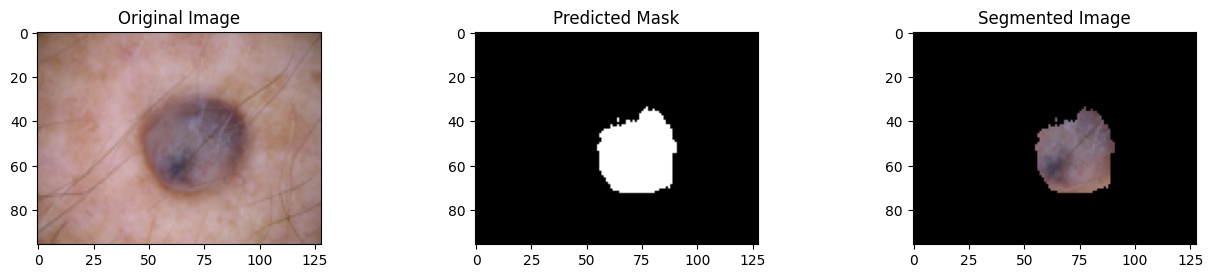

In [135]:
def show_comparison(img_list):
    for i in range(len(img_list)):
        plt.figure(figsize=(16,16))
        plt.subplot(i+1,3,1)
        plt.imshow(img_list[i])
        plt.title('Original Image')
        plt.subplot(i+1,3,2)
        plt.imshow(enhance(img_list[i]).reshape(96, 128), plt.cm.binary_r)
        plt.title('Predicted Mask')
        plt.subplot(i+1,3,3)
        plt.imshow(applyMask(img_list[i]), plt.cm.binary_r)
        plt.title('Segmented Image')
    
show_comparison(img_list)

## Classify Segmented Images

In [ ]:
# from tensorflow import keras

# vgg16_model = keras.models.load_model('vgg16_model.h5')
# resnet50_model = keras.models.load_model('resnet50_model.h5')
# ensemble_model = keras.models.load_model('ensemble_model.h5')

In [136]:
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications.resnet import preprocess_input as resnet50_preprocess_input
from keras.layers import Average


# VGG16 Predictions - Unaltered
validation_batch = np.stack([vgg16_preprocess_input(img) for img in img_list])
pred = vgg16_model.predict(validation_batch)

# VGG16 Predictions - Segmented
segmented_validation_batch = np.stack([vgg16_preprocess_input(img) for img in seg_img_list])
vgg16_seg_pred = vgg16_model.predict(segmented_validation_batch)

# ResNet50 Predictions - Unaltered
resnet_validation_batch = np.stack([resnet50_preprocess_input(img) for img in img_list])
res_pred = resnet50_model.predict(resnet_validation_batch)

# ResNet50 Predictions - Segmented
resnet_segmented_validation_batch = np.stack([resnet50_preprocess_input(img) for img in seg_img_list])
res_seg_pred = resnet50_model.predict(resnet_segmented_validation_batch)

# Ensemble Predictions
e_validation_batch = np.stack([img for img in img_list])
e_seg_validation_batch = np.stack([img for img in img_list])
e_preds = ensemble_model.predict(e_validation_batch)
e_seg_pred = ensemble_model.predict(e_seg_validation_batch)
for p in e_preds: np.random.shuffle(p)
for p in e_seg_pred: np.random.shuffle(p)
print(e_preds)

1/1 [==============================] - 0s 21ms/step
[[3.9702983e-09 6.3674172e-32 4.3952336e-30 1.6166326e-30 1.1169826e-18
  5.0000000e-01 5.0000000e-01]
 [1.0230802e-15 8.2959983e-10 5.0000113e-01 8.5153773e-02 1.5909601e-17
  9.6086996e-19 4.1484511e-01]
 [9.3949011e-06 4.9999058e-01 5.0000000e-01 2.4753537e-28 4.7741048e-26
  2.3447065e-30 1.7711366e-19]
 [5.0000000e-01 4.5412611e-21 3.6373568e-15 2.7213529e-14 2.4484627e-21
  5.4799096e-07 4.9999946e-01]
 [4.3200963e-15 6.2293543e-12 4.9999970e-01 1.7839178e-18 2.8379443e-10
  3.6830153e-30 5.0000030e-01]]


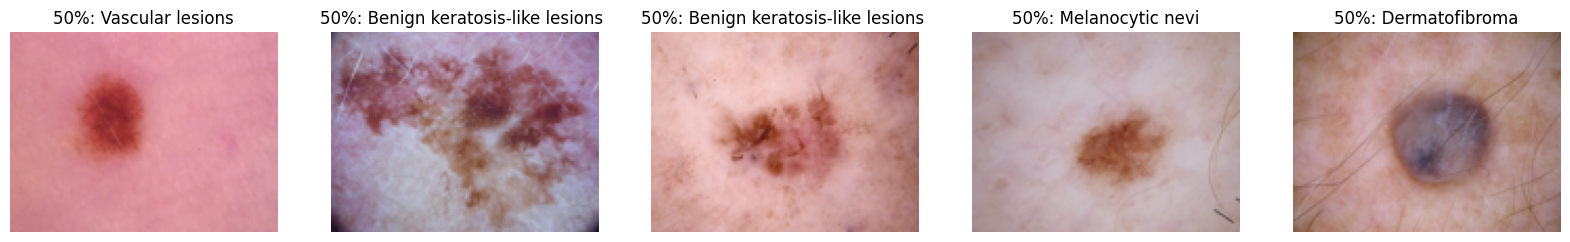

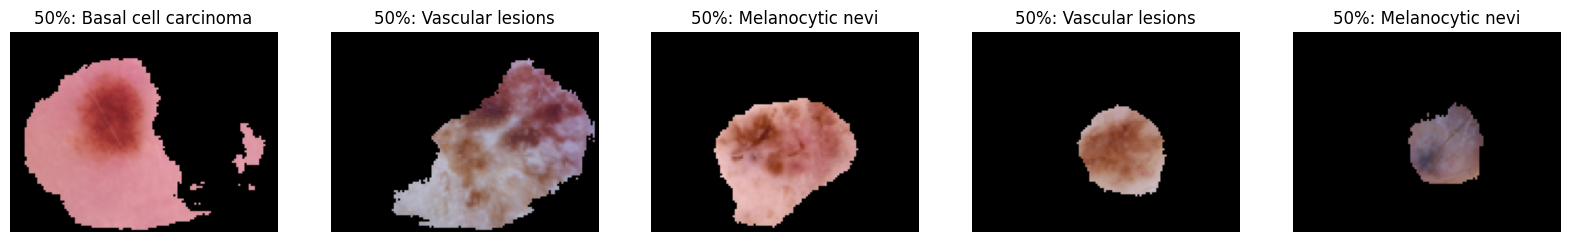

In [137]:
import numpy as np


classes = [
    'Melanocytic nevi',
    'Melanoma',
    'Benign keratosis-like lesions ',
    'Basal cell carcinoma',
    'Actinic keratoses',
    'Vascular lesions',
    'Dermatofibroma'
]

# Unaltered
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    p_idx = np.argmax(e_preds[i])
    title = "{:.0f}%: {:}".format(100*e_preds[i][p_idx], classes[p_idx])
    ax.set_title(title)
    ax.imshow(img)

# Segmented
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(seg_img_list):
    ax = axs[i]
    ax.axis('off')
    p_idx = np.argmax(e_seg_pred[i])
    title = "{:.0f}%: {:}".format(100*e_seg_pred[i][p_idx], classes[p_idx])
    ax.set_title(title)
    ax.imshow(img)

# Graphs

# VGG16

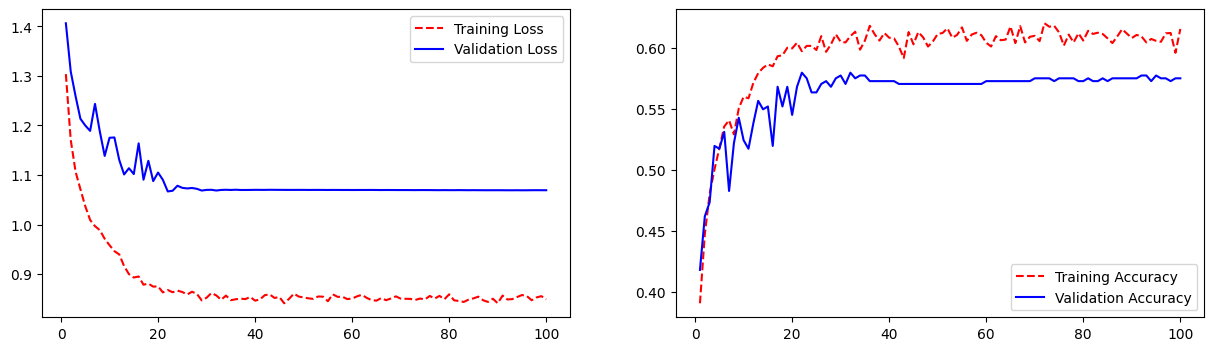

In [142]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

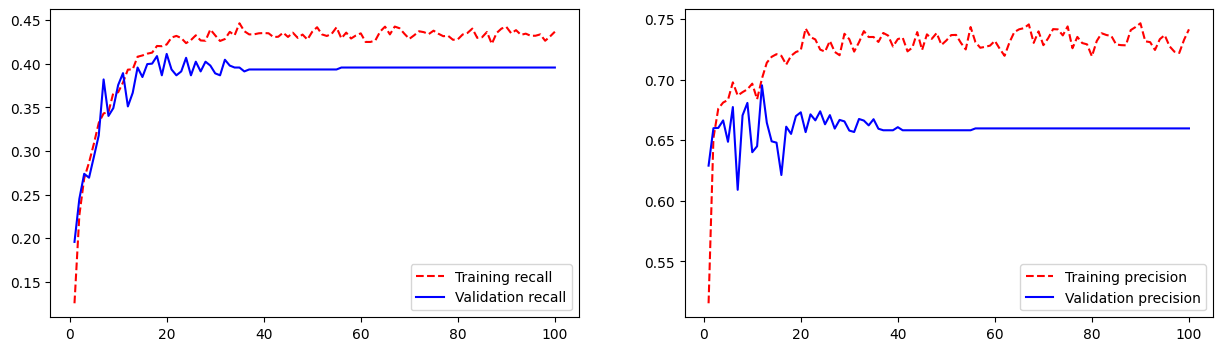

In [143]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_recall = history.history['recall']
validation_recall = history.history['val_recall']
training_precision = history.history['precision']
validation_precision =history.history['val_precision']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_recall, 'r--')
axs[0].plot(epoch_count, validation_recall, 'b-')
axs[0].legend(['Training recall', 'Validation recall'])

axs[1].plot(epoch_count, training_precision, 'r--')
axs[1].plot(epoch_count, validation_precision, 'b-')
axs[1].legend(['Training precision', 'Validation precision'])

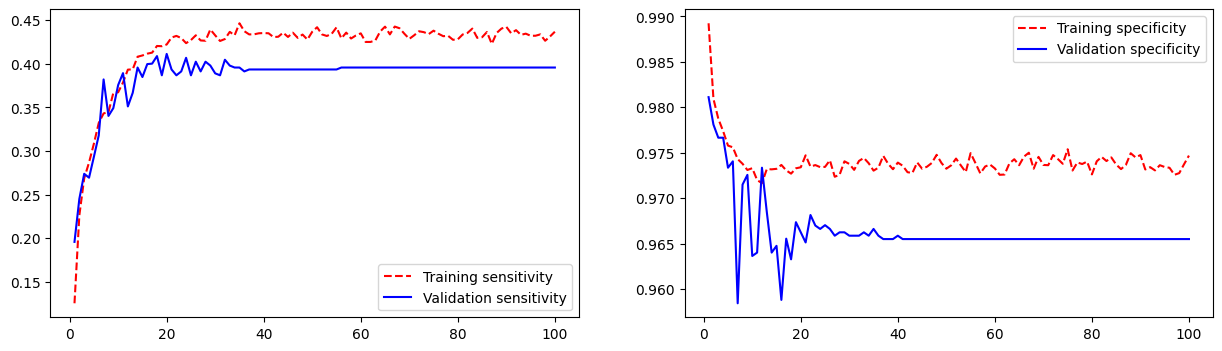

In [144]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_mean_iou =history.history['sensitivity']
validation_mean_iou = history.history['val_sensitivity']

training_specificity = history.history['specificity']
validation_specificity = history.history['val_specificity']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_mean_iou, 'r--')
axs[0].plot(epoch_count, validation_mean_iou, 'b-')
axs[0].legend(['Training sensitivity', 'Validation sensitivity'])

axs[1].plot(epoch_count, training_specificity, 'r--')
axs[1].plot(epoch_count, validation_specificity, 'b-')
axs[1].legend(['Training specificity', 'Validation specificity'])

<Figure size 640x480 with 0 Axes>

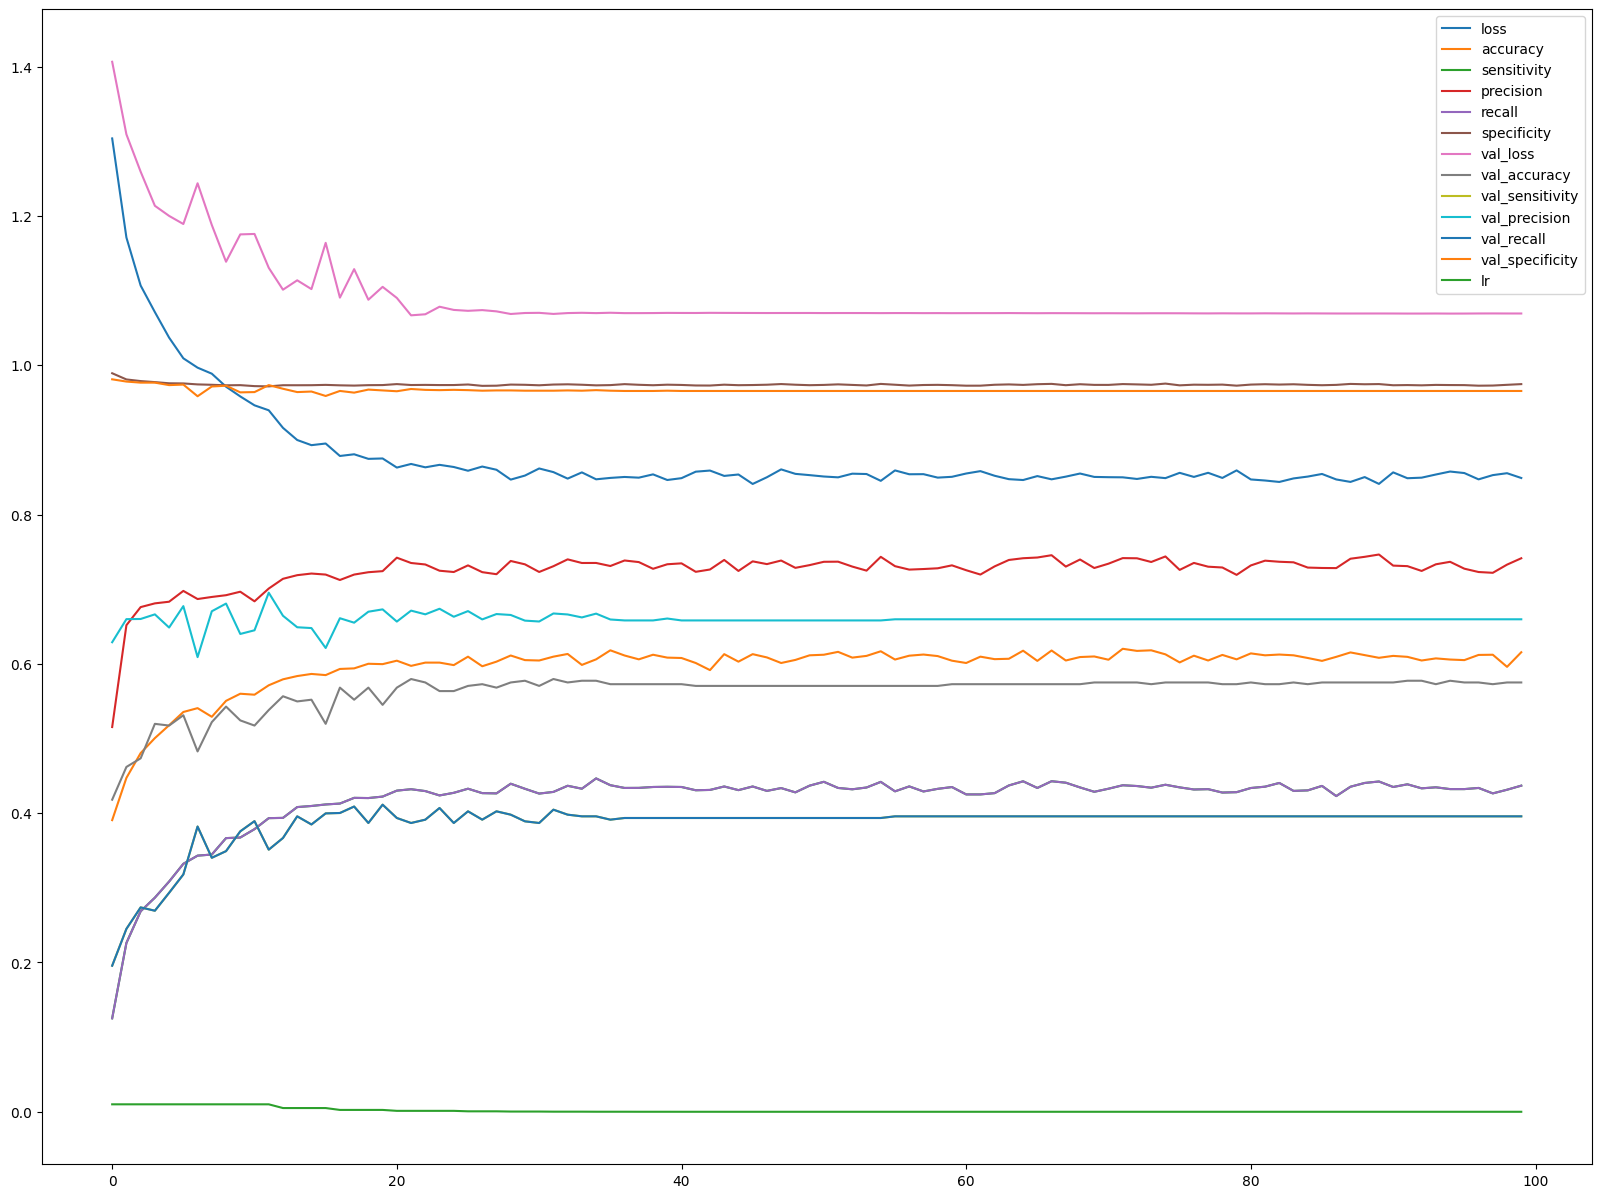

In [154]:
fig1 = plt.gcf()
pd.DataFrame(history.history).plot(figsize=(20,15))
plt.savefig('vgg16.png', dpi=100)
plt.show()


# ResNet50

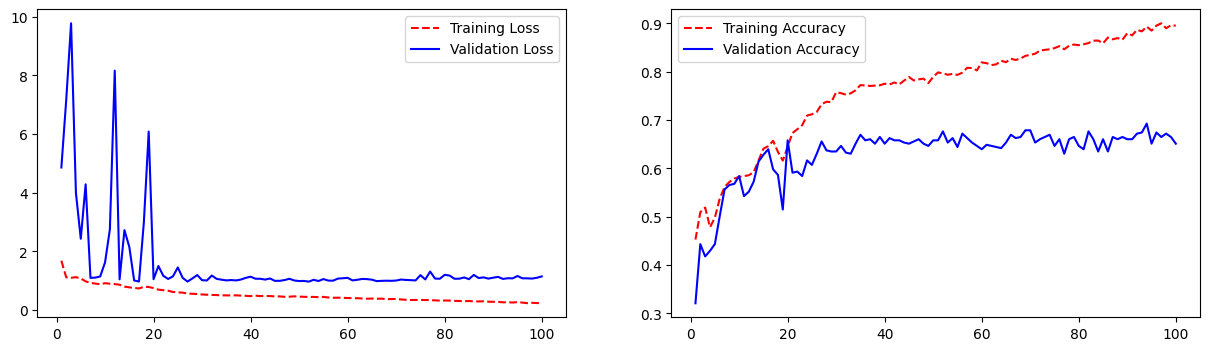

In [145]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = resnet50_history.history['loss']
validation_loss = resnet50_history.history['val_loss']

training_accuracy = resnet50_history.history['accuracy']
validation_accuracy = resnet50_history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

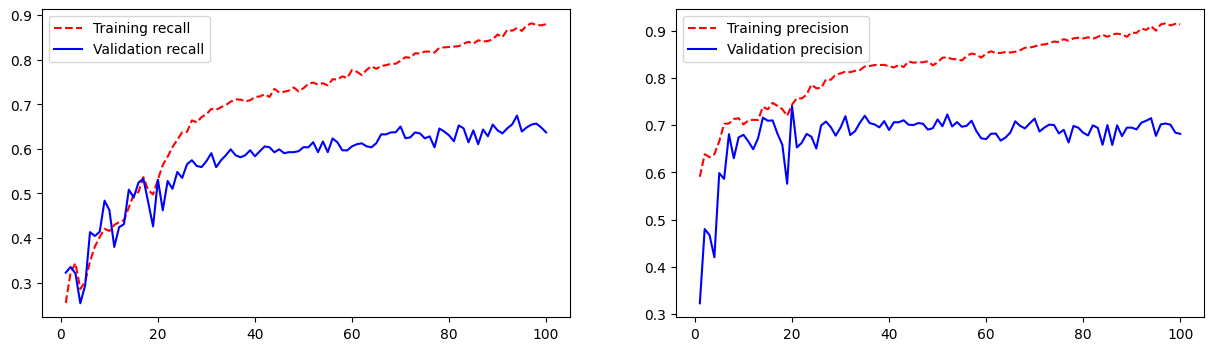

In [146]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_recall = resnet50_history.history['recall']
validation_recall = resnet50_history.history['val_recall']
training_precision = resnet50_history.history['precision']
validation_precision =resnet50_history.history['val_precision']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_recall, 'r--')
axs[0].plot(epoch_count, validation_recall, 'b-')
axs[0].legend(['Training recall', 'Validation recall'])

axs[1].plot(epoch_count, training_precision, 'r--')
axs[1].plot(epoch_count, validation_precision, 'b-')
axs[1].legend(['Training precision', 'Validation precision'])

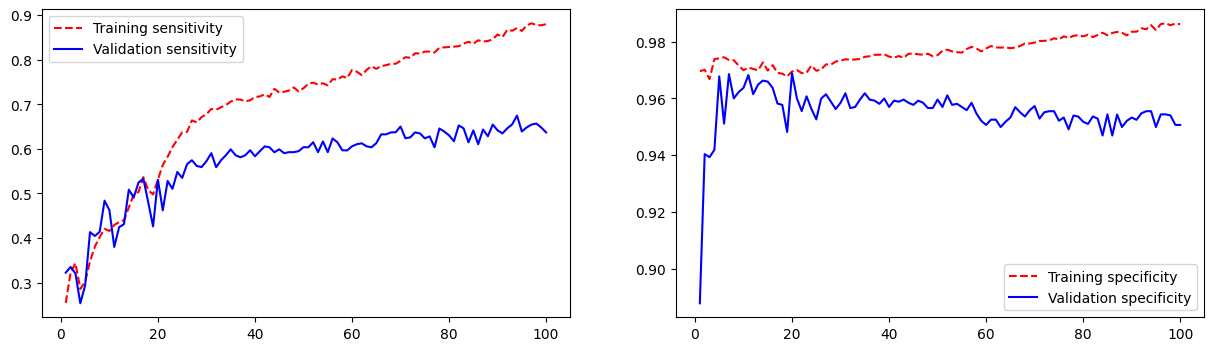

In [147]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_mean_iou =resnet50_history.history['sensitivity']
validation_mean_iou = resnet50_history.history['val_sensitivity']

training_specificity = resnet50_history.history['specificity']
validation_specificity = resnet50_history.history['val_specificity']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_mean_iou, 'r--')
axs[0].plot(epoch_count, validation_mean_iou, 'b-')
axs[0].legend(['Training sensitivity', 'Validation sensitivity'])

axs[1].plot(epoch_count, training_specificity, 'r--')
axs[1].plot(epoch_count, validation_specificity, 'b-')
axs[1].legend(['Training specificity', 'Validation specificity'])

<Figure size 640x480 with 0 Axes>

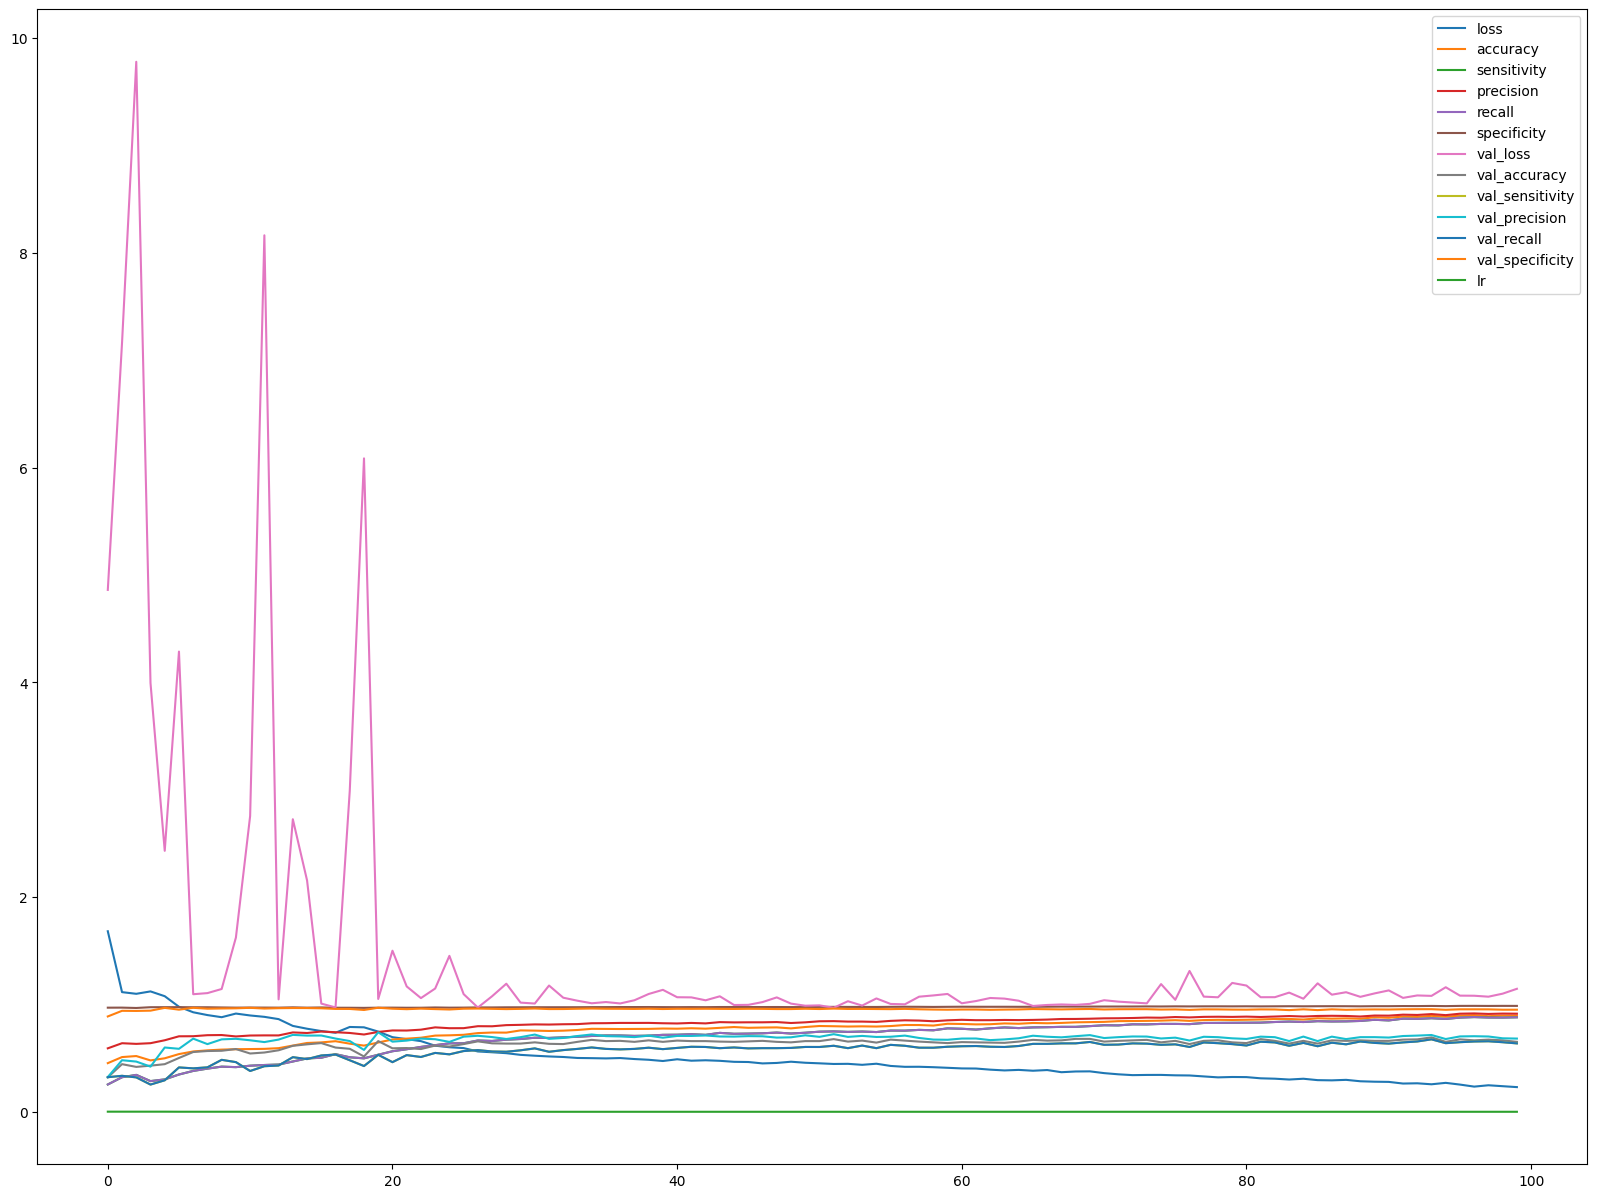

In [165]:
fig2 = plt.gcf()
pd.DataFrame(resnet50_history.history).plot(figsize=(20,15))
plt.savefig('resnet50.png', dpi=100)
plt.show()


In [163]:
exclude_keys = ['val_loss']
new_d = {k: resnet50_history.history[k] for k in set(list(resnet50_history.history.keys())) - set(exclude_keys)}

<Figure size 640x480 with 0 Axes>

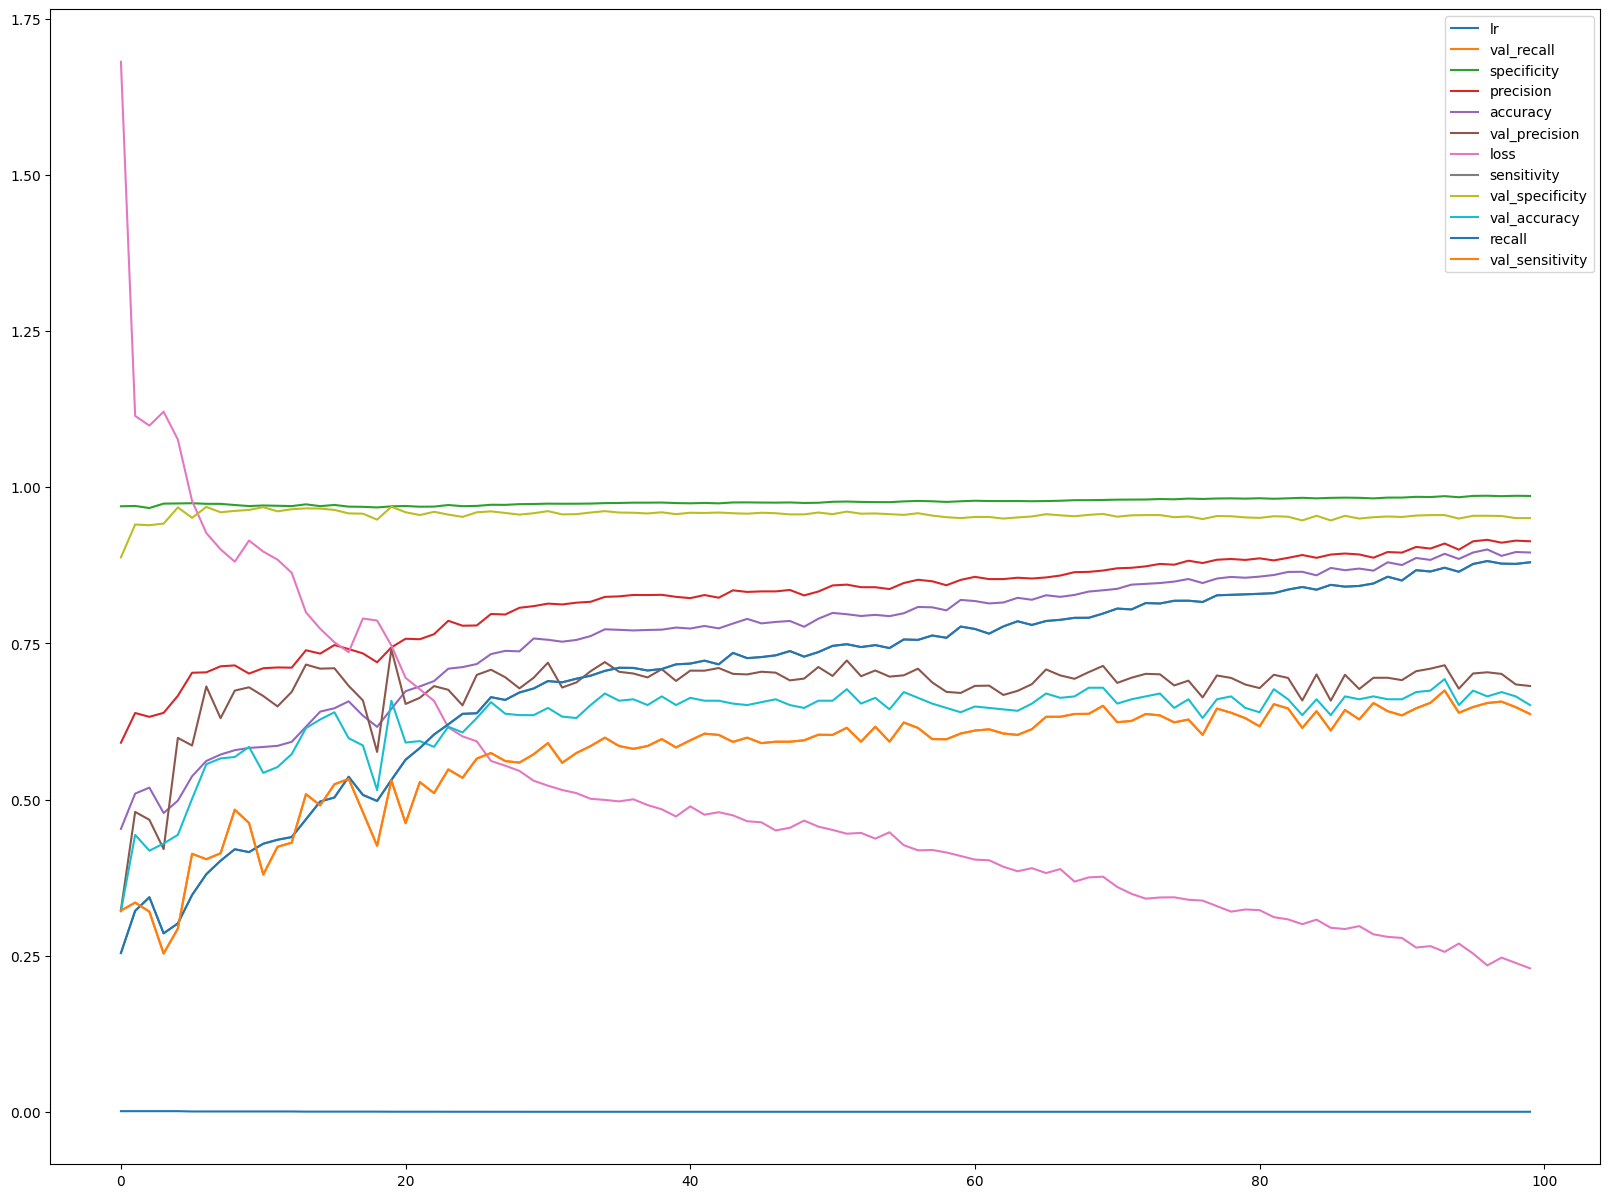

In [166]:
fig3 = plt.gcf()
pd.DataFrame(new_d).plot(figsize=(20,15))
plt.savefig('resnet50_v2.png', dpi=100)
plt.show()

# MobileNet